# Blackjack Simulator

In this notebook, I explored [Jackson Gayda's Blackjack Simulator on Github](https://github.com/jgayda/blackjack-simulator) (shoutout to him for building such a cool tool from scratch!) and made a few modifications to his code to simulate blackjack games over a specified number of hands (e.g., 100 or 1000), and repeated the simulation multiple times (e.g., 10,000 times with 400 hands per run). The results are then plotted to analyze the distributions of final bankrolls.

In [1]:
from enum import Enum, auto
import random
from typing import List
import click
from collections import deque
import matplotlib.pyplot as plt
import numpy as np

## Card

In [2]:
class CardValue(Enum):
    Ace = 1
    Two = 2
    Three = 3
    Four = 4
    Five = 5
    Six = 6
    Seven = 7
    Eight = 8
    Nine = 9
    Ten = 10
    Jack = 11
    Queen = 12
    King = 13

class Suit:
    Clubs = u"\N{BLACK CLUB SUIT}"
    Diamonds = u"\N{WHITE DIAMOND SUIT}"
    Hearts = u"\N{WHITE HEART SUIT}"
    Spades = u"\N{BLACK SPADE SUIT}"
    
class Card:

    def __init__(self, rank: int, suit):
        assert suit in (Suit.Clubs, Suit.Diamonds, Suit.Hearts, Suit.Spades)
        assert 1 <= rank < 14
        self.rank = rank
        self.suit = suit
    
    def getRank(self):
        return self.rank
    
    def getValue(self):
        if self.rank > 10: 
            return 10
        if self.rank == 1:
            # Always returns the hard ace value of 11
            return 11
        return self.rank
    
    def printCard(self):
        suit_symbols = {Suit.Clubs: '''♣''', Suit.Diamonds: '''♦''', Suit.Hearts: '''♥''', Suit.Spades: '''♠'''}
        face_values = {11: "J", 12: "Q", 13: "K", 1: "A"}
        if face_values.__contains__(self.rank):
            print(str(self.suit), face_values.get(self.rank))
        else:
            print(str(self.suit), self.rank)

## Shoe

In [3]:
class Shoe:
    def __init__(self, numDecks, isVerbose):
        assert numDecks >= 1
        self.numDecks = numDecks
        self.isVerbose = isVerbose
        self.discard = []
        self.drawPile = []
        for deck in range(0, numDecks):
            for suit in Suit.Clubs, Suit.Diamonds, Suit.Hearts, Suit.Spades:
                for rank in range (1, 14):
                    self.drawPile.append(Card(rank, suit))
    
    def discardCard(self, card):
        self.discard.append(card)

    def drawCard(self):
        return self.drawPile.pop(0)
    
    def getDecksRemaining(self):
        penetration = self.getPenetration()
        decksRemaining = (1 - penetration) * self.numDecks
        return round(decksRemaining * 2) / 2 # nearest half deck
    
    def getPenetration(self):
        return len(self.discard) / (self.numDecks * 52)

    def printDeck(self):
        for card in self.drawPile:
            card.printCard()
    
    def resetShoe(self):
        if self.isVerbose: print("Resetting shoe...")
        for card in self.discard:
            self.drawPile.append(card)
        self.discard = []
        random.shuffle(self.drawPile)

## Hand

In [4]:
class HandIterator:
    def __init__(self, cards: List[Card]):
        self.index = 0
        self.cards = cards
    
    def __iter__(self):
        return self

    def __next__(self):
        try:
            card = self.cards[self.index]
        except IndexError:
            self.index = 0
            raise StopIteration
        self.index += 1
        return card
        
class Hand:
    def __init__(self, cards: List[Card], betSize: int):
        self.cards = cards
        self.betSize = betSize
        self.insuranceBet = 0
        self.isInsured = False
        self.finalHandValue = 0
    
    def __iter__(self):
        return HandIterator(self.cards)
    
    def addCard(self, card: Card):
        self.cards.append(card)
    
    def doubleDown(self):
        self.betSize = self.betSize * 2

    def insureHand(self):
        self.insuranceBet = self.betSize / 2
        self.isInsured = True
    
    def isBlackjack(self):
        if len(self.cards) != 2:
            return False
        card1Value = self.cards[0].getValue()
        card2Value = self.cards[1].getValue()
        if card1Value + card2Value == 21:
            return True
        return False
    
    def isBust(self):
        return self.getHandValue() > 21

    def isPair(self):
        if len(self.cards) != 2: 
            return False
        card1Rank = self.cards[0].getRank()
        card2Rank = self.cards[1].getRank()
        return card1Rank == card2Rank
    
    def isSoftTotal(self, softTotalDeductionCount):
        if len(self.cards) == 1:
            return False
        numAces = self.getAcesCount()
        if (softTotalDeductionCount == numAces):
            return False
        return numAces != 0
    
    def getAcesCount(self):
        numAces = 0
        for card in self.cards:
            if card.getValue() == 11:
                numAces += 1
        return numAces
    
    def getInitialBet(self):
        return self.betSize

    def getSoftTotalAcelessValue(self, softAcesCount):
        total = 0
        for card in self.cards:
            if card.getValue() != 11:
                total += card.getValue()
        return total + softAcesCount
    
    def printHand(self, playerName):
        print("Player: ", playerName, " has hand:")
        for card in self.cards:
            card.printCard()
    
    def getCards(self):
        return self.cards
    
    def getHandValue(self):
        sum = 0
        for card in self.cards:
            sum += card.getValue()
        return sum
    
    def setFinalHandValue(self, value):
        self.finalHandValue = value

    def splitHand(self):
        return self.cards.pop()


## Count

In [5]:
class HiLoCount:
    def __init__(self):
        self.runningCount = 0
    
    def updateRunningCount(self, cardValue: int):
        if 2 <= cardValue <= 6:
            self.runningCount = self.runningCount + 1
        elif (cardValue == 10 or cardValue == 11):
            self.runningCount = self.runningCount - 1
    
    def getTrueCount(self, decksRemaining: float) -> int:
        return round(self.runningCount / decksRemaining)
    
    def resetCount(self):
        self.runningCount = 0

## Bet

In [6]:
class BetSpreadInterface:
    def getBetSpreads(trueCount: int, tableMin: int, base_amount: int=1) -> int:
        pass
class spread1_4(BetSpreadInterface):
    def __init__(self, base_amount=1):
        self.name = "1-4 Bet Spread"
        self.base_amount = base_amount
    
    # 1-4 Bet Spread
    def getBetSpreads(self, trueCount, tableMin, base_amount=1):
        if trueCount < 0: return 1
        if trueCount > 3: return 4 
        betSpread = {
            0: 1,
            1: 2,
            2: 3,
            3: 4
        }
        return betSpread.get(trueCount) * self.base_amount

class spread1_6(BetSpreadInterface):
    def __init__(self, base_amount=1):
        self.name = "1-6 Bet Spread"
        self.base_amount = base_amount
        
    # 1-6 Bet Spread
    def getBetSpreads(self, trueCount, tableMin, base_amount=1):
        if trueCount < 0: return 1 * self.base_amount
        if trueCount > 5: return 6 * self.base_amount
        betSpread = {
            0: 1,
            1: 2,
            2: 3,
            3: 4,
            4: 5,
            5: 6
        }
        return betSpread.get(trueCount) * self.base_amount

class spread1_8(BetSpreadInterface):
    def __init__(self, base_amount=1):
        self.name = "1-8 Bet Spread"
        self.base_amount = base_amount
        
    # 1-8 Bet Spread
    def getBetSpreads(self, trueCount, tableMin, base_amount=1):
        if trueCount < 0: return 1 * self.base_amount
        if trueCount > 5: return 8 * self.base_amount
        betSpread = {
            0: 1,
            1: 2,
            2: 3,
            3: 4,
            4: 6,
            5: 8
        }
        return betSpread.get(trueCount) * self.base_amount

class spread1_12(BetSpreadInterface):
    def __init__(self, base_amount=1):
        self.name = "1-12 Bet Spread"
        self.base_amount = base_amount
        
    # 1-12 Bet Spread
    def getBetSpreads(self, trueCount, tableMin, base_amount=1):
        if trueCount < 0: return 1 * self.base_amount
        if trueCount > 5: return 12 * self.base_amount
        betSpread = {
            0: 1,
            1: 2,
            2: 4,
            3: 6,
            4: 8,
            5: 12
        }
        return betSpread.get(trueCount) * self.base_amount

## Player

In [7]:
class Player:
    def __init__(self, name, initialBankroll, strategy, betting, isVerbose):
        if isVerbose: print("Creating new player: ", name)
        self.name = name
        self.bankroll = initialBankroll
        self.bankrollSnapshots = [initialBankroll]
        self.strategy = strategy
        self.betting = betting
        self.isVerbose = isVerbose
        self.hands: List[Hand] = []
        self.handData = [0, 0, 0] # [Wins, Losses, Draws]
    
    def calculateBetSize(self, tableMin, trueCount):
        if self.strategy.isCounting:
            return self.betting.getBetSpreads(trueCount, tableMin)
        return tableMin
    
    def canPlay(self):
        return len(self.hands) > 0
    
    def clearHand(self, hand: Hand):
        self.hands.remove(hand)
    
    def clearAllHands(self):
        self.hands.clear()
    
    def getStartingHand(self):
        return self.hands[0]
    
    def splitPair(self, hand: Hand):
        splitHand = Hand([hand.splitHand()], hand.getInitialBet())
        self.updateHand(splitHand)
        return splitHand
    
    def takeBankrollSnapshot(self):
        self.bankrollSnapshots.append(self.bankroll)
        bankrollDiff = self.bankrollSnapshots[len(self.bankrollSnapshots) - 1] - self.bankrollSnapshots[len(self.bankrollSnapshots) - 2]
        if bankrollDiff > 0:
            self.handData[0] += 1
        elif bankrollDiff < 0:
            self.handData[1] += 1
        else:
            self.handData[2] += 1
    
    def updateBankroll(self, amount):
        self.bankroll = self.bankroll + amount
    
    def updateHand(self, hand):
        self.hands.append(hand)

## Dealer

In [8]:
class HouseRules:
    def __init__(self, standValue, DASoffered, RSAoffered, LSoffered, doubleOnSoftTotal):
        self.standValue = standValue
        self.doubleAfterSplitOffered = DASoffered
        self.resplitAcesOffered = RSAoffered
        self.lateSurrenderOffered = LSoffered
        self.doubleOnSoftTotal = doubleOnSoftTotal
        print("HOUSE RULES:")
        print("Dealer stands on ", standValue)
        print("Double after split offered? ", DASoffered)
        print("Players can re-split aces? ", RSAoffered) 
        print("Surrender offered? ", LSoffered)


class Dealer:
    def __init__(self, penetration, shoeSize, houseRules, strategy, isVerbose):
        self.penetration = penetration
        self.shoe = Shoe(shoeSize, isVerbose)
        self.houseRules: HouseRules = houseRules
        self.strategy = strategy
        self.isVerbose = isVerbose
        self.hand: Hand = None
        self.upcard: Card = None
        self.losses = 0
        self.gains = 0
    
    def dealCard(self):
        return self.shoe.drawCard()
    
    def discardDealersCards(self):
        if self.isVerbose: print("Discarding dealer hand: ", self.hand.cards)
        for card in self.hand.cards:
            self.shoe.discardCard(card)
        self.hand = None
        self.upcard = None

    def discardPlayersCards(self, hand: Hand, playerName):
        if self.isVerbose: print("Discarding ", playerName, "'s hand...")
        for card in hand.cards:
            self.shoe.discardCard(card)
    
    def deckPenetrationTooHigh(self):
        return self.shoe.getPenetration() >= self.penetration
    
    def ensureDeckCompleteness(self, isVerbose):
        if (len(self.shoe.discard) + len(self.shoe.drawPile) != self.shoe.numDecks * 52):
            if self.isVerbose: 
                print("Length of discard and draw piles: ", len(self.shoe.discard), " + ", len(self.shoe.drawPile), " = ", len(self.shoe.discard)+len(self.shoe.drawPile))
                print("Should be equal to: ", self.shoe.numDecks * 52)
            raise SystemExit('ERROR: There are cards missing! ')
        return True

    def handlePayout(self, betSize: int, isBlackjack):
        if isBlackjack:
            self.losses += betSize * 1.5
            return betSize * 1.5
        self.losses += betSize
        return betSize
    
    def insuranceIsOffered(self):
        return self.upcard.getValue() == 11

    def setUpCard(self, upcard: Card):
        self.upcard = upcard
    
    def shuffle(self):
        self.shoe.resetShoe()
    
    def updateHand(self, hand: Hand):
        self.hand = hand
    
    def updateGains(self, amount):
        self.gains += amount

## Strategy

In [9]:
class GameActions(Enum):
    HIT = 'H'
    STAND = 'S'
    DOUBLE = 'D'
    
class StrategyInterface:
    def __init__(self, houseRules: HouseRules, isCounting):
        pass
    
    def hardTotalOptimalDecision(self, hand: Hand, dealerUpcard: int, numSoftAces: int):
        pass

    def shouldSplitPair(self, pairValue: int, dealerUpcard: int) -> bool:
        pass

    def softTotalOptimalDecision(self, hand: Hand, dealerUpcard: int, softTotalDeductionCount:int) -> GameActions:
        pass
    
    def willTakeInsurance(self, runningCount) -> None:
        pass

# RandomStrategy represents the strategy of a player who will leave every single game decision up to chance.
# This goes without saying, do not attempt this strategy in a real life casino :)
class RandomStrategy(StrategyInterface):
    def __init__(self, houseRules, isCounting, accuracy):
        self.houseRules = houseRules
        self.isCounting = isCounting
        self.accuracy = accuracy
        self.name = "random"
    
    def hardTotalOptimalDecision(self, hand: Hand, dealerUpcard: int, numSoftAces):
        return random.choice([GameActions.HIT.value, GameActions.STAND.value, GameActions.DOUBLE.value])
    
    def shouldSplitPair(self, pairValue: int, dealerUpcard: int) -> bool:
        return bool(random.getrandbits(1))
    
    def softTotalOptimalDecision(self, hand: Hand, dealerUpcard: int, softTotalDeductionCount: int) -> GameActions:
        return random.choice([GameActions.HIT.value, GameActions.STAND.value, GameActions.DOUBLE.value])
    
    def willTakeInsurance(self, runningCount):
        return bool(random.getrandbits(1))

# CasinoStrategy represents the strategy of a player who will play exactly how the casino plays. In other words,
# if the dealer was an actual player at the table this is who they'd be. 
class CasinoStrategy(StrategyInterface):
    def __init__(self, houseRules: HouseRules, isCounting, accuracy):
        self.name = "casino"
        self.houseRules = houseRules
        self.isCounting = isCounting
        self.accuracy = accuracy
    
    def hardTotalOptimalDecision(self, hand: Hand, dealerUpcard, numSoftAces):
        handValue = hand.getHandValue() - numSoftAces * 10
        if handValue < 17:
            return GameActions.HIT.value
        return GameActions.STAND.value
    
    def shouldSplitPair(self, pairValue: int, dealerUpcard: int):
        # Casinos never split pairs! 
        return False
    
    def softTotalOptimalDecision(self, hand: Hand, dealerUpcard: int, softTotalDeductionCount) -> GameActions:
        acelessTotalVal = hand.getSoftTotalAcelessValue(softTotalDeductionCount)
        if acelessTotalVal >= 6:
            return GameActions.STAND.value
        return GameActions.HIT.value
    
    def willTakeInsurance(self, runningCount) -> None:
        # Casinos never take insurance!
        return False

# See https://www.blackjackapprenticeship.com/wp-content/uploads/2018/08/BJA_Basic_Strategy.jpg for charts
class BasicStrategy(StrategyInterface):
    def __init__(self, houseRules: HouseRules, isCounting, accuracy):
        self.houseRules = houseRules
        self.isCounting = isCounting
        self.accuracy = accuracy
        if self.houseRules.doubleAfterSplitOffered:
            self.DASdeviations()
        if not self.houseRules.doubleOnSoftTotal:
            self.softTotalDeviations()
    
    # Contains the optimal pair splitting strategy given the rank of the player's pair and the
    # dealer's upcard according to Basic Strategy principles. 
        #     A       2      3      4      5      6      7      8      9      10  
    pairSplitting = {
        1:  [True,  True,  True,  True,  True,  True,  True,  True,  True,  True],
        10: [False, False, False, False, False, False, False, False, False, False],
        9:  [False, True,  True,  True,  True,  True,  False, True,  True,  False],
        8:  [True,  True,  True,  True,  True,  True,  True,  True,  True,  True],
        7:  [False, True,  True,  True,  True,  True,  True,  False, False, False],
        6:  [False, False, True,  True,  True,  True,  False, False, False, False],
        5:  [False, False, False, False, False, False, False, False, False, False],
        4:  [False, False, False, False, False, False, False, False, False, False],
        3:  [False, False, False, True,  True,  True,  True,  False, False, False],
        2:  [False, False, False, True,  True,  True,  True,  False, False, False]
    }

    # Contains the optimal hit/stand/double strategy given that the player has one ace and another card
    # of a certain value and the dealer's upcard according to Basic Strategy principles. 
        #    A    2    3    4    5    6    7    8    9    10
    softTotals = {
        10: ["S", "S", "S", "S", "S", "S", "S", "S", "S", "S"],
        9:  ["S", "S", "S", "S", "S", "S", "S", "S", "S", "S"],
        8:  ["S", "S", "S", "S", "S", "D", "S", "S", "S", "S"],
        7:  ["H", "D", "D", "D", "D", "D", "S", "S", "H", "H"],
        6:  ["H", "H", "D", "D", "D", "D", "H", "H", "H", "H"],
        5:  ["H", "H", "H", "D", "D", "D", "H", "H", "H", "H"],
        4:  ["H", "H", "H", "D", "D", "D", "H", "H", "H", "H"],
        3:  ["H", "H", "H", "H", "D", "D", "H", "H", "H", "H"],
        2:  ["H", "H", "H", "H", "D", "D", "H", "H", "H", "H"]
    }

    # Contains the optimal hit/stand/double strategy for the player's cards against the dealer's upcard
    # according to Basic Strategy principles.
        #     A    2    3    4    5    6    7    8    9    10
    hardTotals = {
        17: ["S", "S", "S", "S", "S", "S", "S", "S", "S", "S"],
        16: ["H", "S", "S", "S", "S", "S", "H", "H", "H", "H"],
        15: ["H", "S", "S", "S", "S", "S", "H", "H", "H", "H"],
        14: ["H", "S", "S", "S", "S", "S", "H", "H", "H", "H"],
        13: ["H", "S", "S", "S", "S", "S", "H", "H", "H", "H"],
        12: ["H", "H", "H", "S", "S", "S", "H", "H", "H", "H"],
        11: ["D", "D", "D", "D", "D", "D", "D", "D", "D", "D"],
        10: ["H", "D", "D", "D", "D", "D", "D", "D", "D", "H"],
        9:  ["H", "H", "D", "D", "D", "D", "H", "H", "H", "H"],
        8:  ["H", "H", "H", "H", "H", "H", "H", "H", "H", "H"],
    }
    # Handles pair splitting deviations in the event that double-after-split (DAS) is offered.
    def DASdeviations(self):
        self.pairSplitting.update({6: [False, True, True,  True,  True,  True,  False, False, False, False]})
        self.pairSplitting.update({4: [False, False, False, False, True, True, False, False, False, False]})
        self.pairSplitting.update({3: [False, True, True, True,  True,  True,  True,  False, False, False]})
        self.pairSplitting.update({2: [False, True, True, True,  True,  True,  True,  False, False, False]})
    
    def hardTotalOptimalDecision(self, hand: Hand, dealerUpcard: int, numSoftAces):
        if random.randrange(0,1) > self.accuracy:
            return random.choice([GameActions.HIT.value, GameActions.STAND.value, GameActions.DOUBLE.value])
        handValue = hand.getHandValue() - numSoftAces * 10
        if handValue <= 8:
            return GameActions.HIT.value
        if handValue >= 17:
            return GameActions.STAND.value
        return self.hardTotals.get(handValue)[dealerUpcard - 2] # dealer's upcard ranges from 2-11 and since python is a 0-based index

    def shouldSplitPair(self, pairValue: int, dealerUpcard: int):
        if dealerUpcard == 11:
            dealerUpcard = 1
        if pairValue == 11:
            return self.pairSplitting.get(1)[dealerUpcard - 1]
        return self.pairSplitting.get(pairValue)[dealerUpcard - 1]
    
    # Handles soft total deviations in the event that players cannot double on a soft total.
    def softTotalDeviations(self):
        self.softTotals.update({8: ["S", "S", "S", "S", "S", "S", "S", "S", "S", "S"]})
        self.softTotals.update({7: ["H", "S", "S", "S", "S", "S", "S", "S", "H", "H"]})
        self.softTotals.update({6: ["H", "H", "H", "H", "H", "H", "H", "H", "H", "H"]})
        self.softTotals.update({5: ["H", "H", "H", "H", "H", "H", "H", "H", "H", "H"]})
        self.softTotals.update({4: ["H", "H", "H", "H", "H", "H", "H", "H", "H", "H"]})
        self.softTotals.update({3: ["H", "H", "H", "H", "H", "H", "H", "H", "H", "H"]})
        self.softTotals.update({2: ["H", "H", "H", "H", "H", "H", "H", "H", "H", "H"]})
    
    def softTotalOptimalDecision(self, hand: Hand, dealerUpcard: int, softTotalDeductionCount):
        if random.randrange(0,1) > self.accuracy:
            return random.choice([GameActions.HIT.value, GameActions.STAND.value, GameActions.DOUBLE.value])
        acelessTotalVal = hand.getSoftTotalAcelessValue(softTotalDeductionCount)

        if len(hand.cards) == 2 and hand.cards[0].getValue() == 11 and hand.cards[1].getValue() == 11:
            # You may choose to return SPLIT or HIT if not allowed
            if self.shouldSplitPair(11, dealerUpcard):
                print("Pair of Aces: choosing to SPLIT based on strategy.")
                return GameActions.HIT.value  # placeholder, or define GameActions.SPLIT if supported
            else:
                print("Pair of Aces: not splitting, fallback to HIT.")
                return GameActions.HIT.value
        
        if acelessTotalVal >= 8:
            return GameActions.STAND.value
        if dealerUpcard == 11:
            dealerUpcard = 1
            
        strategy_row = self.softTotals.get(acelessTotalVal)
        
        if strategy_row is None:
            print("=== ERROR TRACE ===")
            print(f"acelessTotalVal: {acelessTotalVal}")
            print(f"softTotals keys: {list(self.softTotals.keys())}")
            print(f"dealerUpcard: {dealerUpcard}")
            print(f"Hand: {[card.getValue() for card in hand.cards]}")
            print("===================")
            raise ValueError(f"acelessTotalVal={acelessTotalVal} not found in softTotals")
        
        chartVal = strategy_row[dealerUpcard - 1]
        return chartVal
    
    def willTakeInsurance(self, runningCount):
        # Perfect basic strategy never takes insurance unless running count is exceptionally high
        return runningCount >= 8


## Blackjack Game

In [10]:
isVerbose = False
vprint = print if isVerbose else lambda *a, **k,: None

def main(shoesize=6, bankroll=10000, hands=1000, tablemin=10, penetration=0.84, dealersettings=[17, True, True, True, True], verbose=False):
    print("Running blackjack simulation with variables:")
    print("Shoe size: ", shoesize)
    print("Bankroll: ", bankroll)
    print("Number of hands to simulate: ", hands)
    print("Minimum Table Bet: ", tablemin)
    print()
    houseRules = HouseRules(standValue=dealersettings[0], DASoffered=dealersettings[1], RSAoffered=dealersettings[2], LSoffered=dealersettings[3], doubleOnSoftTotal=dealersettings[4])
    game = BlackJackGame(shoesize, bankroll, hands, tablemin, penetration, houseRules)
    global isVerbose
    isVerbose = verbose
    game.startGame()
    gamedata = GameData(game)
    gamedata.getDealerStatistics()
    gamedata.getPlayerStatistics()
    gamedata.plotBankrollTime()

class GameData:
    def __init__(self, game):
        self.game: BlackJackGame = game
        self.players = self.game.players
        self.dealer = self.game.dealer
        self.bankrollData = {}
        self.getPlayerBankrollSnapshots()
    
    def getPlayerBankrollSnapshots(self):
        for player in self.players:
            self.bankrollData.update({player.name: player.bankrollSnapshots})
    
    def getDealerStatistics(self):
        print()
        print(" - - - - - ")
        print("Dealer losses: $", self.dealer.losses, " | Dealer gains: $", self.dealer.gains, " | Profit: $", self.dealer.gains - self.dealer.losses)
        print(" - - - - - ")
        print()
    def getPlayerStatistics(self):
        for player in self.players:
            handsPlayed = len(player.bankrollSnapshots) - 1
            winRate = player.handData[0] / handsPlayed * 100
            loseRate = player.handData[1] / handsPlayed * 100
            drawRate = player.handData[2] / handsPlayed * 100
            endBankroll = player.bankroll
            initialBankroll = player.bankrollSnapshots[0]
            diff = endBankroll - initialBankroll
            earningsPerHand = diff / handsPlayed
            percentChange = (endBankroll - initialBankroll) / initialBankroll * 100
            print(player.name, ":")
            print("Win %", round(winRate,1), " | Lose %", round(loseRate,1), " | Draw %", round(drawRate,1))
            print("Earnings: ", diff, '(Percent Increase %', round(percentChange,1), ") | Average payout per hand: $", earningsPerHand)
            print()
    def plotBankrollTime(self):
        numHands = self.game.numHands
        playerNames = []
        fig, ax = plt.subplots(figsize=(12,6))
        for player in self.players:
            ax.plot([item for item in range(1, len(player.bankrollSnapshots) + 1)], player.bankrollSnapshots, label=player.name)
            playerNames.append(player.name)
        ax.set_title("Plot of players' bankroll over time in a blackjack game of "+str(numHands)+" rounds")
        ax.set_xlabel("Round number")
        ax.set_ylabel("Bankroll ($)")
        
        # Add the legend
        pos = ax.get_position()
        ax.set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
        ax.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), title="Players")
        plt.tight_layout()
        plt.show()

class BlackJackGame:
    def __init__(self, shoeSize, bankroll, hands, tableMin, penetration, houseRules):
        vprint("Initializing game...")
        self.shoeSize = shoeSize
        self.numHands = hands
        self.tableMin = tableMin

        vprint("Dealer has rules: ")
        vprint("Deck Penetration %: ", penetration, " | Minimum table bet: $", tableMin)
        self.dealer = Dealer(penetration, shoeSize, houseRules, CasinoStrategy(houseRules, isCounting=False, accuracy=1), isVerbose)

        self.players = [Player("Counting with 1-4 Bet Spread", bankroll, BasicStrategy(houseRules, isCounting=True, accuracy=1), spread1_4(base_amount=20), isVerbose),
                        Player("Counting with 1-6 Bet Spread", bankroll, BasicStrategy(houseRules, isCounting=True, accuracy=1), spread1_6(base_amount=20), isVerbose),
                        Player("Counting with 1-8 Bet Spread", bankroll, BasicStrategy(houseRules, isCounting=True, accuracy=1), spread1_8(base_amount=20), isVerbose),
                        Player("Counting with 1-12 Bet Spread", bankroll, BasicStrategy(houseRules, isCounting=True, accuracy=1), spread1_12(base_amount=20), isVerbose),
                        Player("Perfect Basic Strategy", bankroll, BasicStrategy(houseRules, isCounting=False, accuracy=1), spread1_4(base_amount=20), isVerbose),
                        Player('99% Accurate Basic Strategy', bankroll, BasicStrategy(houseRules, isCounting=False, accuracy=0.99), spread1_4(base_amount=20), isVerbose),
                        Player('95% Accurate Basic Strategy', bankroll, BasicStrategy(houseRules, isCounting=False, accuracy=0.95), spread1_4(base_amount=20), isVerbose),
                        Player('80% Accurate Basic Strategy', bankroll, BasicStrategy(houseRules, isCounting=False, accuracy=0.80), spread1_4(base_amount=20), isVerbose),
                        Player('Casino Rules', bankroll, CasinoStrategy(houseRules, isCounting=False, accuracy=1), spread1_6(base_amount=20), isVerbose),
                        Player("Random", bankroll, RandomStrategy(houseRules, isCounting=False, accuracy=1), spread1_6(base_amount=20), isVerbose)]
        vprint("There are ", len(self.players), " players in the game.")
    
    def clearAllCards(self, players: List[Player]):
        # Collect the cards from each player before moving onto the next round and put the cards in the
        # discard pile
        for player in players:
            for hand in player.hands:
                if isVerbose: hand.printHand(player.name)
                self.dealer.discardPlayersCards(hand, player.name)
            
            player.clearAllHands()
        
        # Discard the dealer's cards and move them to the discard pile
        self.dealer.discardDealersCards()

    def dealDealersHand(self, count):
        # Deal out the dealers cards
        upcard = self.dealer.dealCard()
        self.dealer.setUpCard(upcard)
        count.updateRunningCount(upcard.getValue())
        # The hidden card is not added to the count yet as only the dealer knows this information
        hiddenCard = self.dealer.dealCard()
        dealerHand = Hand([upcard, hiddenCard], 0)
        self.dealer.updateHand(dealerHand)
        vprint("Dealer shows:")
        if isVerbose: upcard.printCard()
        vprint("Dealer hides:")
        if isVerbose: hiddenCard.printCard()

    def dealPlayersHands(self, players, count):
        vprint("Dealing hands...")
        for player in players:
            betSize = player.calculateBetSize(self.tableMin, self.getTrueCount(count))

            card1: Card = self.dealer.dealCard()
            card2: Card = self.dealer.dealCard()

            count.updateRunningCount(card1.getValue())
            count.updateRunningCount(card2.getValue())

            player.updateBankroll(-1 * betSize)
            player.updateHand(Hand([card1, card2], betSize))
            if isVerbose: player.getStartingHand().printHand(player.name)
    
    def doubleDown(self, player: Player, hand: Hand, count: HiLoCount):
        vprint("Doubling down!")
        player.updateBankroll(-1 * hand.getInitialBet())
        hand.doubleDown()
        self.hit(player, hand, count)
    
    def getTrueCount(self, count: HiLoCount):
        decksRemaining = self.dealer.shoe.getDecksRemaining()
        trueCount = count.getTrueCount(decksRemaining)
        return trueCount
    
    def handleBustHand(self, player: Player, hand: Hand):
        vprint("Hand went bust.")
        self.dealer.updateGains(hand.getInitialBet())
        self.dealer.discardPlayersCards(hand, player.name)
        player.clearHand(hand)
    
    def handleDealerBlackjack(self, players: List[Player], count: HiLoCount):
        # Need to update the count as the dealer reveals the hidden card to show blackjack
        # Guaranteed to have a count value of -1
        count.updateRunningCount(10)

        for player in players:
            for hand in player.hands:
                if hand.isBlackjack():
                    vprint("Player ", player.name, " pushes with another blackjack.")
                    player.updateBankroll(hand.betSize)
                elif hand.isInsured:
                    vprint("Player ", player.name, "'s hand is insured!")
                    player.updateBankroll(hand.betSize + hand.insuranceBet)
                else:
                    self.dealer.updateGains(hand.betSize)
    
    def handleInsurance(self, players: List[Player], count: HiLoCount):
        vprint("Dealer shows ace - Insurance offered")
        trueCount = self.getTrueCount(count)
        for player in players:
            for hand in player.hands:
                if player.strategy.willTakeInsurance(trueCount) and not hand.isBlackjack():
                    player.updateBankroll(-1 * hand.betSize / 2)
                    hand.insureHand()
                    vprint("Player ", player.name, " has insured their hand.")
        vprint("Insurance closed.")

    def handlePlayerBlackjack(self, player: Player, hand: Hand):
        payout = self.dealer.handlePayout(hand.betSize, isBlackjack=True)
        vprint("Blackjack! Initial bet: $", hand.getInitialBet(), " Payout: $", payout)
        player.updateBankroll(hand.betSize + payout)
        self.dealer.discardPlayersCards(hand, player.name)
        player.clearHand(hand)
    
    def handleRemainingHands(self, players: List[Player]):
        dealerValue = self.dealer.hand.finalHandValue
        for player in players:
            for hand in player.hands:
                vprint(player.name, " has ", hand.finalHandValue, " against the dealer's ", dealerValue)
                if hand.finalHandValue > dealerValue:
                    vprint("Player wins!")
                    payout = self.dealer.handlePayout(hand.betSize, isBlackjack=False)
                    vprint("Initial bet: $", hand.getInitialBet(), " Payout: $", payout)
                    player.updateBankroll(hand.betSize + payout)
                elif hand.finalHandValue < dealerValue:
                    vprint("Player loses!")
                    self.dealer.updateGains(hand.betSize)
                else:
                    vprint("Player pushes.")
                    player.updateBankroll(hand.betSize)

    def handleSplitPair(self, player: Player, hand: Hand, dealerUpcard: Card, count: HiLoCount):
        vprint("Determining whether or not to split pair based on player's strategy...")
        trueCount = self.getTrueCount(count)
        if player.strategy.shouldSplitPair(hand.getHandValue() / 2, dealerUpcard.getValue()) and player.calculateBetSize(self.tableMin, trueCount) <= player.bankroll:
            vprint("Splitting pair!")
            splitHand = player.splitPair(hand)
            return splitHand
        vprint("Player decided not to split pair.")
        return None

    
    def hit(self, player: Player, hand: Hand, count: HiLoCount):
        hitCard = self.dealer.dealCard()
        count.updateRunningCount(hitCard.getValue())
        hand.addCard(hitCard)
        vprint(player.name, " has new hand: ")
        if isVerbose: hand.printHand(player.name)

    def playDealerHand(self, count):
        vprint("Dealer is now playing their hand...")
        action: GameActions = None
        softTotalDeductionCount = 0

        while (action != GameActions.STAND.value):
            if self.dealer.hand.isBust():
                if softTotalDeductionCount < self.dealer.hand.getAcesCount():
                    vprint("Dealer busts! Ace now becomes 1. Old hand value: ", self.dealer.hand.getHandValue(), " New value: ", self.dealer.hand.getHandValue() - 10)
                    softTotalDeductionCount += 1
                else:
                    vprint("Dealer busts! All players are rewarded")
                    break
            if self.dealer.hand.isSoftTotal(softTotalDeductionCount) and softTotalDeductionCount < self.dealer.hand.getAcesCount():
                vprint("Dealer has soft total.")
                action = self.dealer.strategy.softTotalOptimalDecision(self.dealer.hand, self.dealer.upcard, softTotalDeductionCount)
            else:
                vprint("Dealer has hard total...")
                action = self.dealer.strategy.hardTotalOptimalDecision(self.dealer.hand, self.dealer.upcard.getValue(), softTotalDeductionCount)
            
            if (action == GameActions.HIT.value):
                vprint("Dealer hits...")
                hitCard = self.dealer.dealCard()
                count.updateRunningCount(hitCard.getValue())
                self.dealer.hand.addCard(hitCard)
                vprint("Dealer now has hand: ")
                if isVerbose: self.dealer.hand.printHand("Dealer")
            elif (action == GameActions.STAND.value):
                vprint("Dealer will stand...")
                self.dealer.hand.setFinalHandValue(self.dealer.hand.getHandValue() - softTotalDeductionCount * 10)
                break

    def playHands(self, player: Player, dealerUpcard: Card, handNumber, count):
        dealtHand = player.getStartingHand()
        vprint(player.name, " is playing their hand...")

        # Check if the dealt hand is a blackjack and payout immediately if it is
        if dealtHand.isBlackjack():
            self.handlePlayerBlackjack(player, dealtHand)
        else:
            handQueue = deque()
            handQueue.append(player.getStartingHand())

            while len(handQueue) > 0:
                hand = handQueue.pop()
                action: GameActions = None
                softTotalDeductionCount = 0

                while (action != GameActions.STAND.value):
                    if hand.isBust():
                        if softTotalDeductionCount < hand.getAcesCount():
                            vprint("BUST! Ace now becomes 1. Old hand value: ", hand.getHandValue(), " New value: ", hand.getHandValue() - 10)
                            softTotalDeductionCount += 1
                        else:
                            vprint("BUST! Value is: ", hand.getHandValue() - softTotalDeductionCount * 10)
                            self.handleBustHand(player, hand)
                            break
                    if hand.isPair():
                        vprint("We have a pair...")
                        splitHand = self.handleSplitPair(player, hand, dealerUpcard, count)
                        if splitHand is not None:
                            handQueue.append(splitHand)
                            handQueue.append(hand)
                            break
                    
                    if hand.isSoftTotal(softTotalDeductionCount) and softTotalDeductionCount < hand.getAcesCount():
                        vprint("We have a soft total...")
                        action = player.strategy.softTotalOptimalDecision(hand, dealerUpcard.getValue(), softTotalDeductionCount)
                    else:
                        # Get hard total value
                        vprint("We have a hard total of ", hand.getHandValue()- softTotalDeductionCount * 10)
                        action = player.strategy.hardTotalOptimalDecision(hand, dealerUpcard.getValue(), softTotalDeductionCount)
                    if (action == GameActions.HIT.value):
                        vprint("Player is gonna hit!")
                        self.hit(player, hand, count)
                    elif (action == GameActions.STAND.value):
                        vprint("Player will stand")
                        hand.setFinalHandValue(hand.getHandValue() - softTotalDeductionCount * 10)
                        break
                    elif (action == GameActions.DOUBLE.value):
                        vprint("Double down!")
                        self.doubleDown(player, hand, count)
                    
        vprint(player.name, " has played all of their hands!")
    
    def printRoundInformation(self, players: List[Player], count: HiLoCount, roundNumber: int):
        print(" - - - - - - - - - - -")
        print(" - - - - - - - - - - -")
        print("Round: ", roundNumber, " Running Count: ", count.runningCount)
        print(" - - - - - - - - - - -")
        print(" - - - - - - - - - - -")
        for player in players:
            prevIndex = len(player.bankrollSnapshots) - 2
            print(player.name, ' has a bankroll of $', player.bankroll, " (Prev hand: $", player.bankrollSnapshots[prevIndex], ")")
    
    def startGame(self):
        self.dealer.shuffle()
        vprint("Starting new blackjack game!")

        handCount = 1
        playersInGame: List[Player] = []
        playersInBreak: List[Player] = []

        for player in self.players:
            playersInGame.append(player)
            vprint("Player: ", player.name, " has joined the game.")

        count = HiLoCount()

        # Play the game! 
        while (handCount <= self.numHands and len(playersInGame) > 0):
            if isVerbose:
                self.printRoundInformation(playersInGame, count, handCount)
            # Deal out the players' and dealer's cards
            self.dealPlayersHands(playersInGame, count)
            self.dealDealersHand(count)

            # If the dealer shows an ace, dealer will offer insurance to all players.
            if self.dealer.insuranceIsOffered():
                self.handleInsurance(playersInGame, count)
            
            # If the dealer was dealt a blackjack, all players automatically lose UNLESS they too have a blackjack
            if self.dealer.hand.isBlackjack():
                self.handleDealerBlackjack(playersInGame, count)
            else:
                # Allow players to play out each of their hands
                for player in playersInGame:
                    self.playHands(player, self.dealer.upcard, handCount, count)
            
            # Now, the dealer will play out their hand
            self.playDealerHand(count)

            # Next, determine which existing hands beat the dealer and perform all necessary payouts
            self.handleRemainingHands(playersInGame)
        
            handCount = handCount + 1

            self.clearAllCards(playersInGame)

            # Used to debug deck sizes to ensure that no cards are being lost:
            self.dealer.ensureDeckCompleteness(isVerbose=True)
            
            # If we have exceeded or reached optimal shoe penetration, reset the shoe and the running count
            if self.dealer.deckPenetrationTooHigh():
                self.dealer.shuffle()
                count.resetCount()
            
            
            for player in playersInGame:
                player.takeBankrollSnapshot()
                if player.bankroll < self.tableMin:
                    vprint(player.name, " has gone broke and is out of the game.")
                    playersInGame.remove(player)

Running blackjack simulation with variables:
Shoe size:  6
Bankroll:  3000
Number of hands to simulate:  1000
Minimum Table Bet:  10

HOUSE RULES:
Dealer stands on  17
Double after split offered?  True
Players can re-split aces?  True
Surrender offered?  True

 - - - - - 
Dealer losses: $ 112647.0  | Dealer gains: $ 113845  | Profit: $ 1198.0
 - - - - - 

Counting with 1-4 Bet Spread :
Win % 47.4  | Lose % 45.4  | Draw % 7.2
Earnings:  2351.0 (Percent Increase % 78.4 ) | Average payout per hand: $ 2.351

Counting with 1-6 Bet Spread :
Win % 44.0  | Lose % 47.8  | Draw % 8.2
Earnings:  1250.0 (Percent Increase % 41.7 ) | Average payout per hand: $ 1.25

Counting with 1-8 Bet Spread :
Win % 46.4  | Lose % 42.8  | Draw % 10.8
Earnings:  6350.0 (Percent Increase % 211.7 ) | Average payout per hand: $ 6.35

Counting with 1-12 Bet Spread :
Win % 46.7  | Lose % 46.4  | Draw % 6.9
Earnings:  6300.0 (Percent Increase % 210.0 ) | Average payout per hand: $ 6.3

Perfect Basic Strategy :
Win % 44.

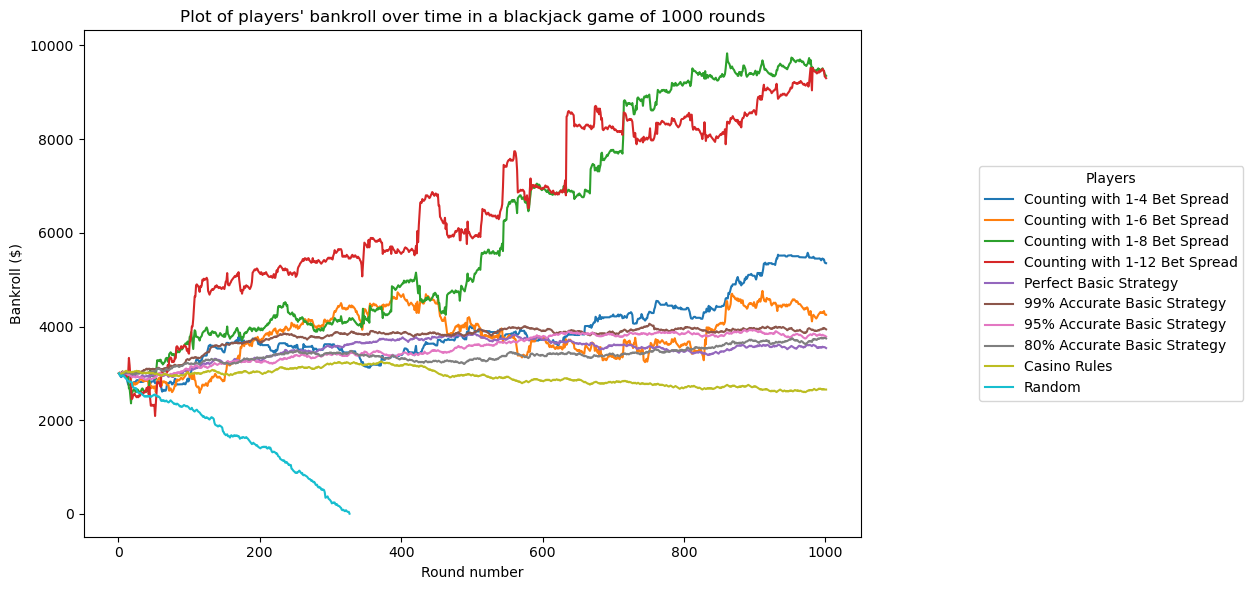

In [14]:
main(
    shoesize=6,
    bankroll=3000,
    hands=1000,
    tablemin=10,
    penetration=0.84,
    dealersettings=[17, True, True, True, True], 
    # [Dealer stands, DAS, Re-Split Aces, Late Surrender, Double on Soft Total]
    verbose=False
)

In [15]:
import matplotlib.pyplot as plt
from collections import defaultdict

def run_multiple_simulations(num_simulations=100, **kwargs):
    final_bankrolls = defaultdict(list)

    for i in range(num_simulations):
        print(f"Running simulation {i + 1}/{num_simulations}")
        houseRules = HouseRules(standValue=kwargs['dealersettings'][0],
                                DASoffered=kwargs['dealersettings'][1],
                                RSAoffered=kwargs['dealersettings'][2],
                                LSoffered=kwargs['dealersettings'][3],
                                doubleOnSoftTotal=kwargs['dealersettings'][4])
        
        game = BlackJackGame(kwargs['shoesize'], kwargs['bankroll'], kwargs['hands'], kwargs['tablemin'], kwargs['penetration'], houseRules)
        game.startGame()

        for player in game.players:
            final_bankrolls[player.name].append(player.bankroll)

    return final_bankrolls

def plot_final_bankroll_histograms(final_bankrolls, initial_bankroll=10000):
    num_players = len(final_bankrolls)
    fig, axs = plt.subplots(nrows=(num_players + 1) // 2, ncols=2, figsize=(14, 4 * ((num_players + 1) // 2)))
    axs = axs.flatten()

    for i, (player_name, bankrolls) in enumerate(final_bankrolls.items()):
        mean_bankroll = sum(bankrolls) / len(bankrolls)
        
        axs[i].hist(bankrolls, bins=20, alpha=0.75, color='skyblue', edgecolor='black')
        axs[i].set_title(f'{player_name} Final Bankrolls')
        axs[i].set_xlabel('Bankroll')
        axs[i].set_ylabel('Frequency')
        
        # Red dashed line for mean
        axs[i].axvline(x=mean_bankroll, color='red', linestyle='dashed', linewidth=2, label='Mean')
        
        # Black solid line for initial bankroll
        axs[i].axvline(x=initial_bankroll, color='black', linestyle='solid', linewidth=2, label='Initial Bankroll')

        axs[i].legend()

    plt.tight_layout()
    plt.show()

In [16]:
final_bankrolls = run_multiple_simulations(
    num_simulations=10000,
    shoesize=6,
    bankroll=3000,
    hands=100,
    tablemin=10,
    penetration=0.80,
    dealersettings=[17, True, True, True, True],
    verbose=False
)

Running simulation 1/10000
HOUSE RULES:
Dealer stands on  17
Double after split offered?  True
Players can re-split aces?  True
Surrender offered?  True
Running simulation 2/10000
HOUSE RULES:
Dealer stands on  17
Double after split offered?  True
Players can re-split aces?  True
Surrender offered?  True
Running simulation 3/10000
HOUSE RULES:
Dealer stands on  17
Double after split offered?  True
Players can re-split aces?  True
Surrender offered?  True
Running simulation 4/10000
HOUSE RULES:
Dealer stands on  17
Double after split offered?  True
Players can re-split aces?  True
Surrender offered?  True
Running simulation 5/10000
HOUSE RULES:
Dealer stands on  17
Double after split offered?  True
Players can re-split aces?  True
Surrender offered?  True
Running simulation 6/10000
HOUSE RULES:
Dealer stands on  17
Double after split offered?  True
Players can re-split aces?  True
Surrender offered?  True
Running simulation 7/10000
HOUSE RULES:
Dealer stands on  17
Double after split of

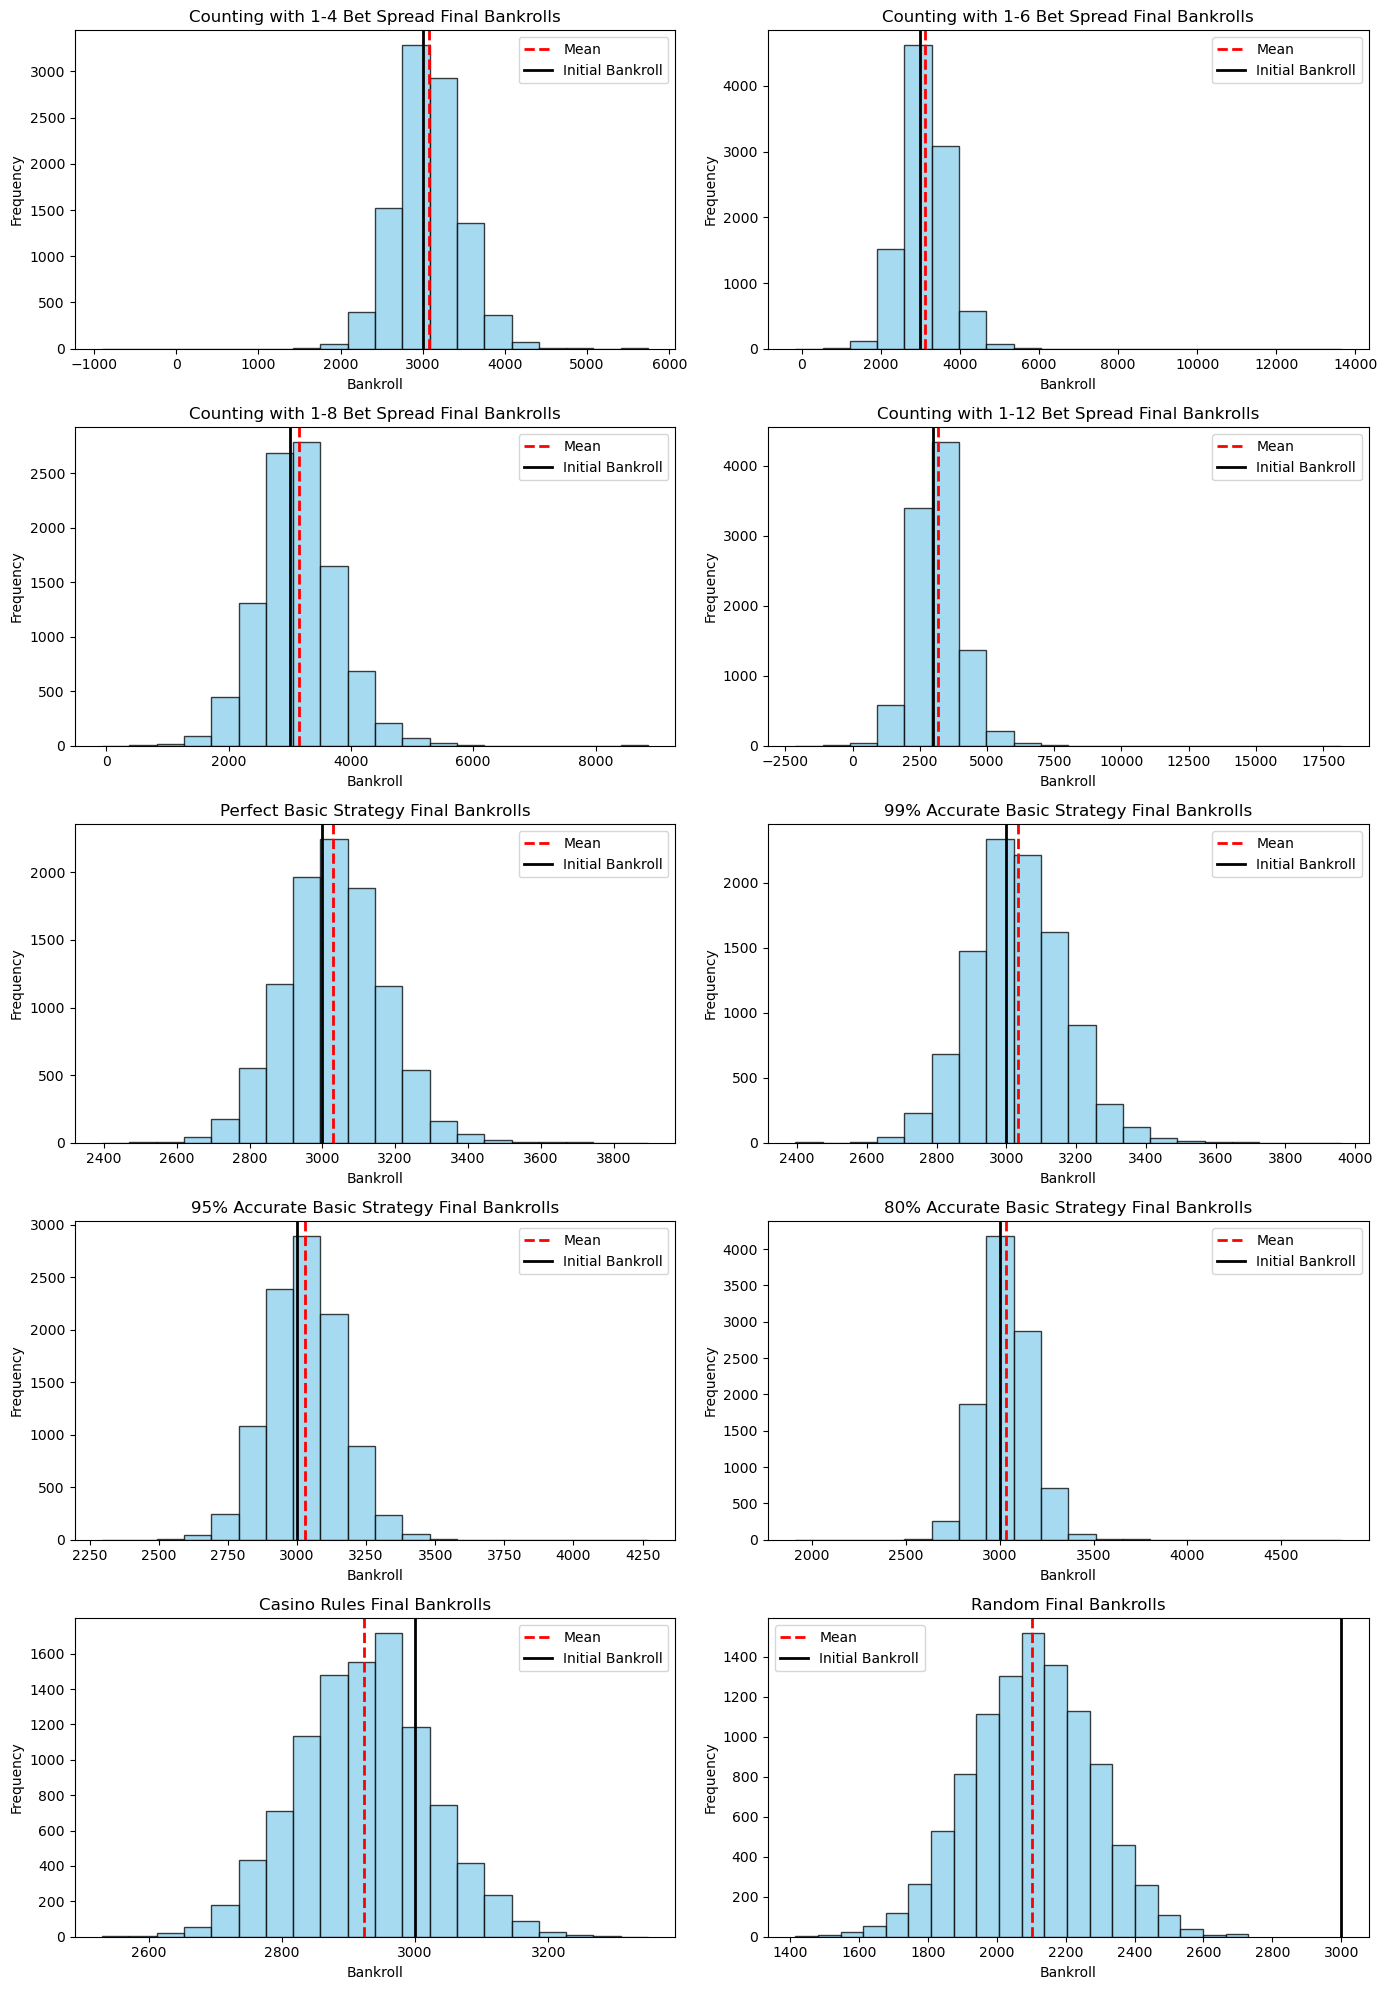

In [17]:
plot_final_bankroll_histograms(final_bankrolls, initial_bankroll=3000)